### The goal of this project is to predict the Crude Oil prices. Monthly petroleum prices can be found at the [Energy Information Administration](https://www.eia.gov/dnav/pet/pet_pri_spt_s1_m.htm). Ever relevant, [Wikipedia](https://en.wikipedia.org/wiki/World_oil_market_chronology_from_2003) has a great write-up on recent trends in oil prices. Also, there is this [Times](http://content.time.com/time/business/article/0,8599,1859380,00.html) article on the spike and drop in 2008.

### Introduction:

Tthere are different types of crude oil – the thick, unprocessed liquid that drillers extract below the earth – and some are more desirable than others. Also, where the oil comes from also makes a difference. Because of these nuances, we need benchmarks to value the commodity based on its quality and location. Thus, Brent, WTI and Dubai/Oman serve this important purpose. Here, I use the most important WTI to demonstrate the world crude oil price changes.

West Texas Intermediate (WTI) – WTI refers to oil extracted from wells in the U.S. and sent via pipeline to Cushing, Oklahoma. The product itself is very light and very sweet, making it ideal for gasoline refining, in particular. WTI continues to be the main benchmark for oil consumed in the United States. Brent Blend – Roughly two-thirds of all crude contracts around the world reference Brent Blend, making it the most widely used marker of all. These days, “Brent” actually refers to oil from four different fields in the North Sea: Brent, Forties, Oseberg and Ekofisk. Crude from this region is light and sweet, making them ideal for the refining of diesel fuel, gasoline. For more information see [Wikipedia](https://en.wikipedia.org/wiki/West_Texas_Intermediate) article. 
 

In [1]:
# Import required packages

%matplotlib inline
import matplotlib
import seaborn as sns
import quandl
import numpy as np
import scipy as sp
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Time Series
<!-- requirement: images/ts_xval.png -->
<!-- requirement: projects/timeseries-project -->

Time series prediction or forecasting presents its own challenges which are different from machine-learning problems.  

Let's first define our time-series as

$$ \{X_t, t = \ldots, -1, 0, 1, \ldots\} \, . $$

In general, while we could use regression to make predictions, the goal of time series analysis is to take advantage of the temporal nature of the data to make more sophisticated models.

**Why not regression** : In typical time series analysis, the depended variables are missing. For exmaple, a simple linear regression would take a form of 

$$ Y = \beta_0 + \beta_1 X_1 + ...$$

where X_1, X_2 ... are unknown. All we know is Y as a function of time.

Here are a few concepts related to time series.  We take $\varepsilon \sim N(0, \sigma^2)$ to be i.i.d. normal errors.  
1. **Stationarity**.  Informally, this means that the distribution of the $X_t$ is independent of time $t$.  Formally, a time-series is stationary if for all $k \ge 0$ and $t$, the following two $k$-tuples have the same distribution:
$$ (X_0,\ldots,X_k) \sim (X_t,\ldots,X_{t+k}) $$
1. **Drift**.  One reason a time-series might not be stationary is that it possess a drift.  For example, we know that prices tend to creep up with inflation.  Mathematically, we might represent the (log) prices as
$$ X_t = \mu t + \varepsilon_t $$
1. **Seasonality**.  Another reason a time-series might not be stationary is that it posseses a seasonal component.  For example, we know that the temperature increases in the summer and decreases in the winter.  A simple model of this might be
$$ X_t = \alpha \sin(\omega t) + \beta \cos(\omega t)$$


### Get Crudeoil price dataset

In [2]:
# To really use the Quandl API. Limited usage doesn't require authtoken.

authtoken = None
# authtoken = "your token here"

def get_quandl(what):
    """ 
    Wrapper around Quandl requests, using authtoken only if available
    """
    if authtoken:
        return quandl.get(what, authtoken=authtoken)
    else:
        return quandl.get(what)

In [3]:
oil = get_quandl("DOE/RWTC") # This creates pandas data frame

In [4]:
oil.head(5)

,Value
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


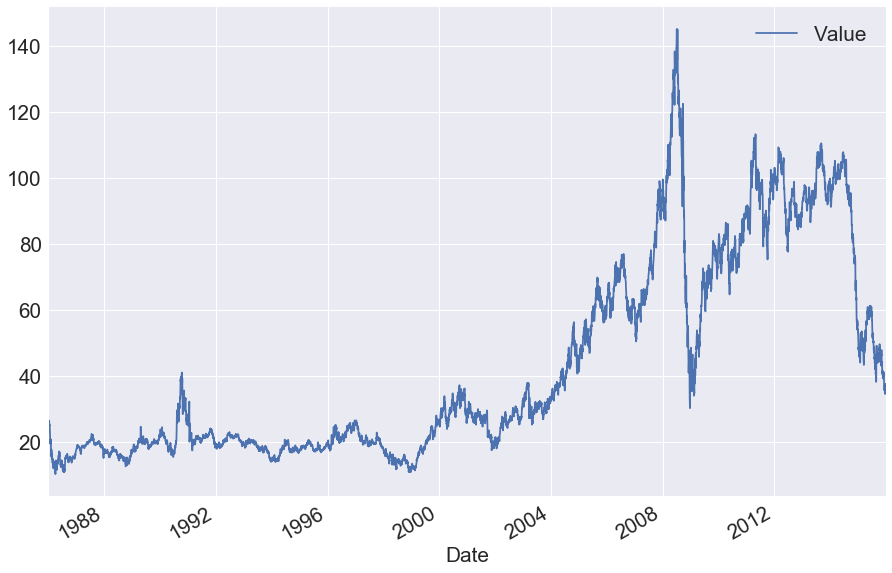

In [5]:
oil.plot()

In [6]:
oil['Julian'] = oil.index.to_julian_date()
oil = sm.add_constant(oil) # Add a constant field for the linear regression

In [7]:
oil.head(5)

,const,Value,Julian
Date,,,
1986-01-02,1.0,25.56,2446432.5
1986-01-03,1.0,26.00,2446433.5
1986-01-06,1.0,26.53,2446436.5
1986-01-07,1.0,25.85,2446437.5
1986-01-08,1.0,25.87,2446438.5


In [8]:
oil.tail(5)

,const,Value,Julian
Date,,,
2015-12-21,1.0,34.55,2457377.5
2015-12-22,1.0,36.12,2457378.5
2015-12-23,1.0,36.76,2457379.5
2015-12-24,1.0,37.62,2457380.5
2015-12-28,1.0,36.36,2457384.5


In [9]:
oil.shape

(7570, 3)

## 1. Let's first check linear regression and support vector regression (SVR) model:

/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be remov

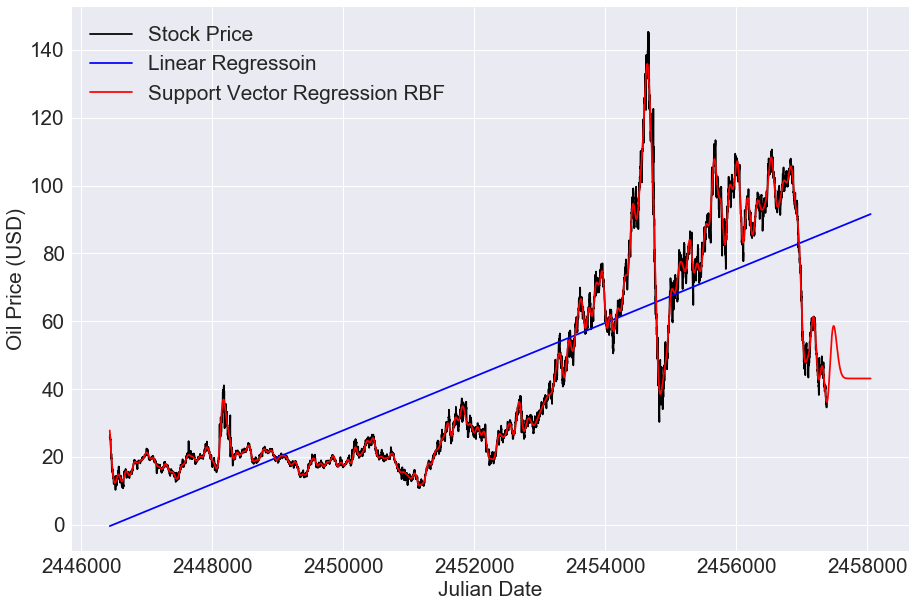

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt

future_days = []
future_price = []


# Create model

days = oil["Julian"].to_frame()
price = oil["Value"].to_frame()

linear = LinearRegression().fit(days, price)
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.0001).fit(days, price)


# Extend a number of days for forecasting the future 
last_day = 2457384.5
for i in range(1, 666):
    future_days.append([last_day + i])
    future_price.append(np.nan)

    
# Convert back to float, so, divide every element by 100
linear_pred = list(map(lambda x: float(x), linear.predict(days)))
linear_pred_future = list(map(lambda x: float(x), linear.predict(future_days)))
svr_rbf_pred = list(map(lambda x: float(x), svr_rbf.predict(days)))
svr_rbf_pred_future = list(map(lambda x: float(x), svr_rbf.predict(future_days)))


# Plot data out
plt.hold('on')
plt.plot(days, price, color='black', label='Stock Price')
plt.plot(days, linear_pred, color='blue', label='Linear Regressoin')
plt.plot(future_days, linear_pred_future, color='blue')
plt.plot(days, svr_rbf_pred, color='red', label='Support Vector Regression RBF')
plt.plot(future_days, svr_rbf_pred_future, color='red')
plt.xlabel('Julian Date')
plt.ylabel('Oil Price (USD)')
plt.legend(loc=2)
plt.show()

In [11]:
len(future_days)

665

In [12]:
len(future_price)

665

## 2. Exponential Model:

In [13]:
oil.head(2)

,const,Value,Julian
Date,,,
1986-01-02,1.0,25.56,2446432.5
1986-01-03,1.0,26.00,2446433.5


In [14]:
# We can actually train a simple exponential model using the log(value), then train further models on the error.
exponential_model = sklearn.linear_model.Ridge().fit( 
    X=oil[['Julian', 'const']], 
    y=np.log(oil['Value'])
)

exp_model_df = oil
exp_model_df['Exponential_Model'] = np.exp(exponential_model.predict(oil[['Julian', 'const']]))
exp_model_df['Log_Error_Exponential'] = np.log(oil['Value'] / oil['Exponential_Model'])

In [15]:
oil.head(2)

,const,Value,Julian,Exponential_Model,Log_Error_Exponential
Date,,,,,
1986-01-02,1.0,25.56,2446432.5,12.254436,0.735141
1986-01-03,1.0,26.00,2446433.5,12.256711,0.752023


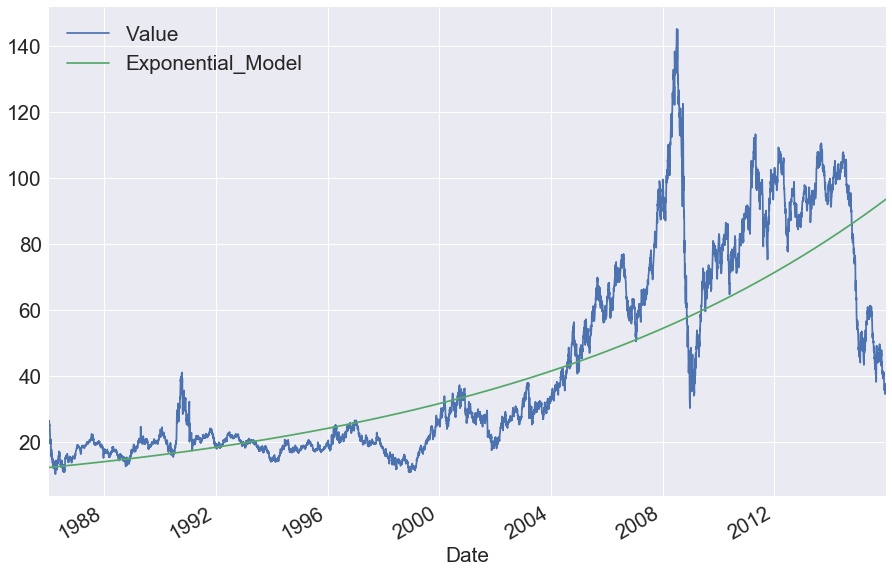

In [16]:
exp_model_df[['Value', 'Exponential_Model']].plot()

## Advanced Time Series Models:

### Check for Stationarity in a series?

***Plotting Rolling Statistics:*** Plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

**Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be accepted or rejected. The result must be interpreted for a given problem to be meaningful.

***Null Hypothesis (H0):*** If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

***Alternate Hypothesis (H1):*** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. 

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

***p-value > 0.05: *** Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

***p-value <= 0.05: *** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=365)
    rolstd = pd.rolling_std(timeseries, window=365)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
  """
/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).std()
  


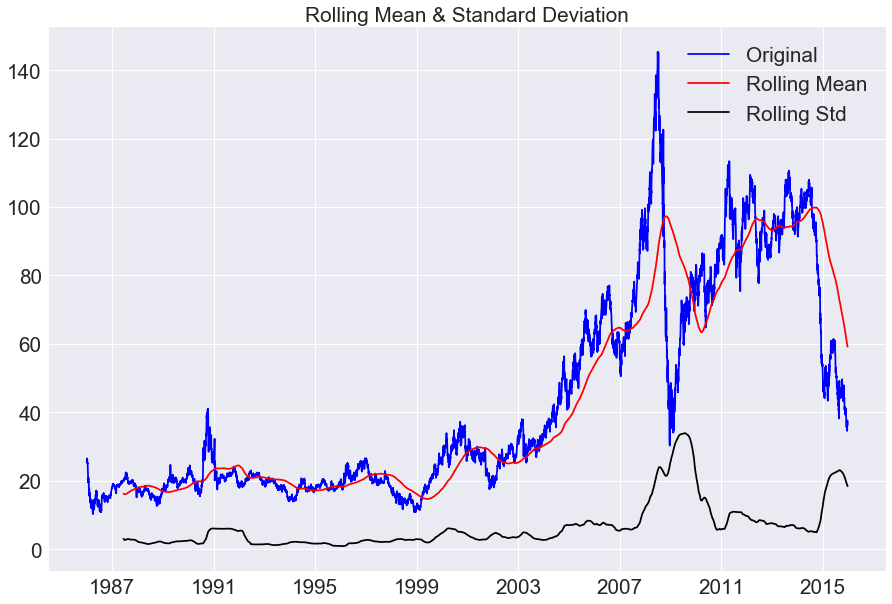

Results of Dickey-Fuller Test:
Test Statistic                   -1.908353
p-value                           0.328142
#Lags Used                       33.000000
Number of Observations Used    7536.000000
Critical Value (5%)              -2.861924
Critical Value (1%)              -3.431218
Critical Value (10%)             -2.566974
dtype: float64


In [18]:
test_stationarity(oil['Value'])

This suggests that we can accept the null hypothesis with a significance level i.e., **the series isn't stationary**.


## Make a Time Series Stationary

There are 2 major reasons behind non-stationaruty of a TS:

1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the oil prices are growing over time.

2. **Seasonality** – variations at specific time-frames. 

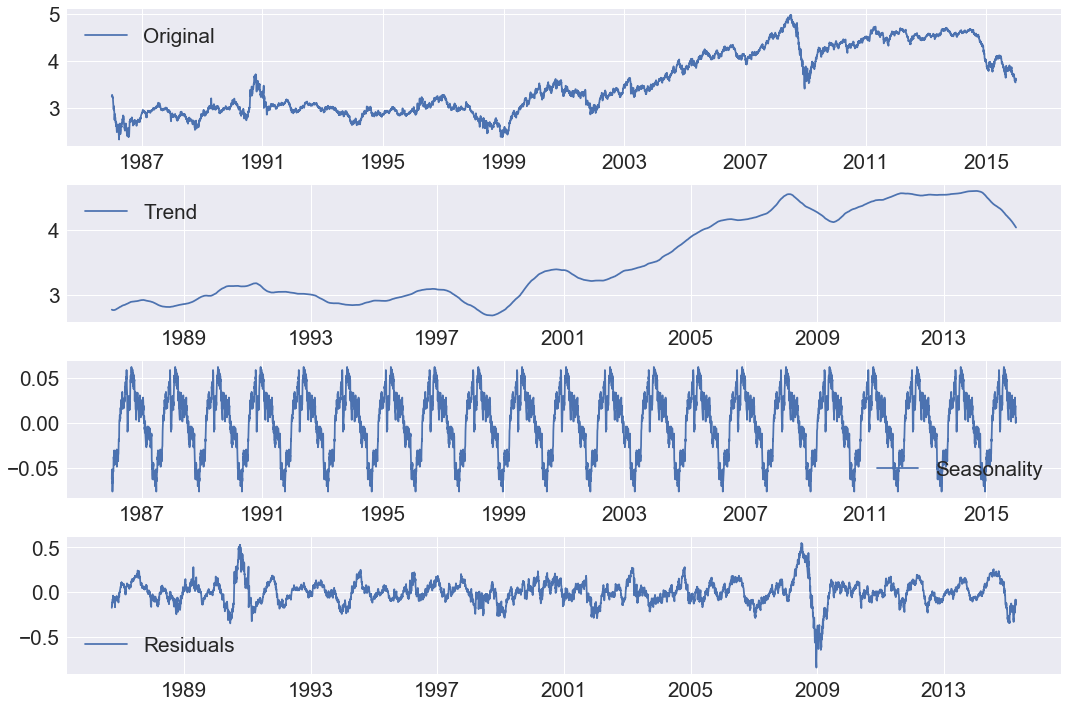

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_log = np.log(oil['Value'])

decomposition = seasonal_decompose(ts_log, freq = 365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
  """
/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).std()
  


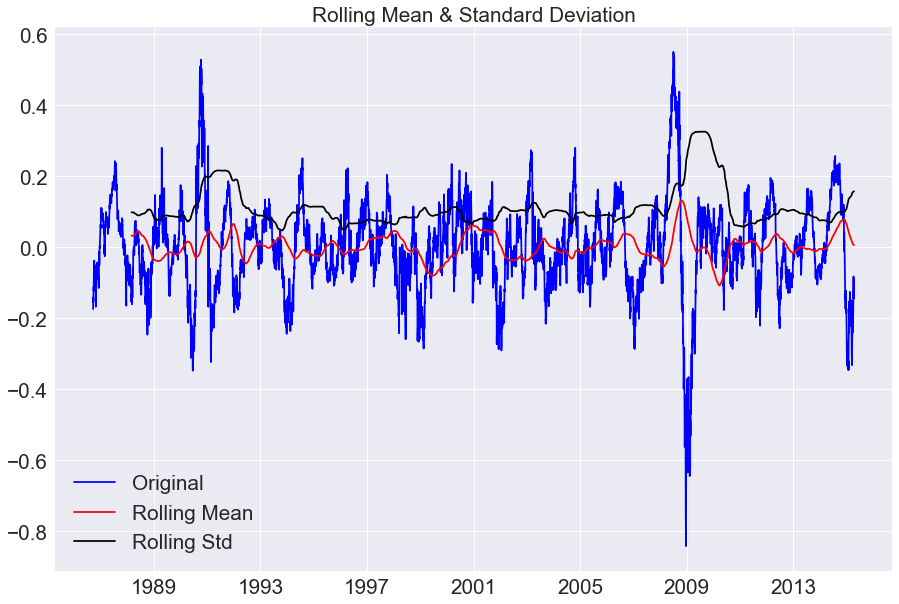

Results of Dickey-Fuller Test:
Test Statistic                -8.061441e+00
p-value                        1.638895e-12
#Lags Used                     2.500000e+01
Number of Observations Used    7.180000e+03
Critical Value (5%)           -2.861943e+00
Critical Value (1%)           -3.431261e+00
Critical Value (10%)          -2.566984e+00
dtype: float64


In [21]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. 

The residual apprears stationary so **Number of Differences (d)= 1**.

## AutoCorrelation Function (ACF)

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

I calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.



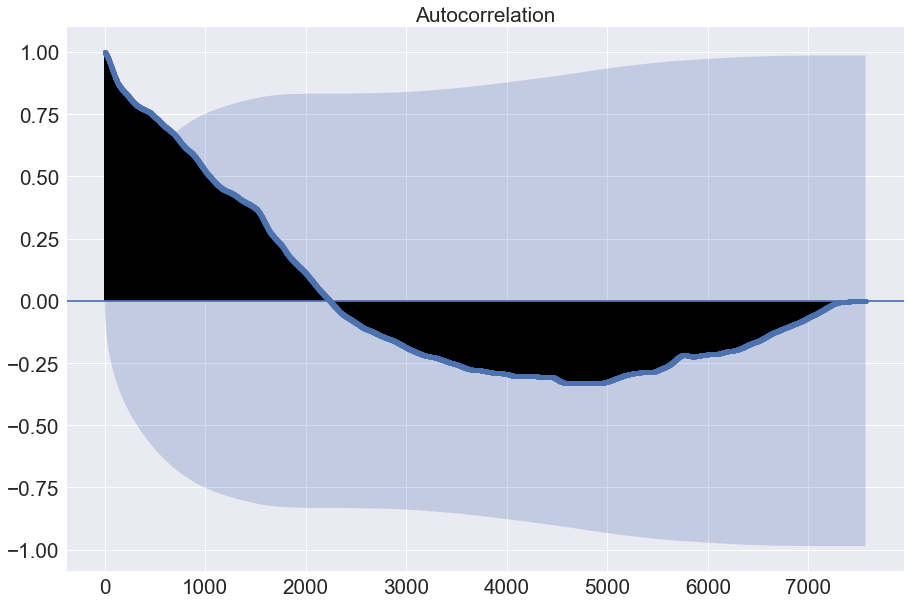

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(oil['Value'])
plt.show()

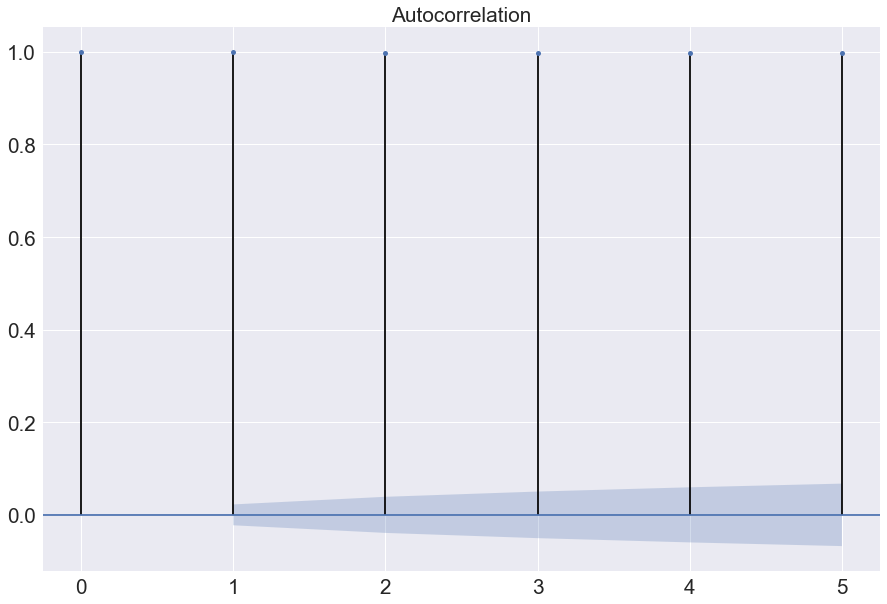

In [24]:
plot_acf(oil['Value'], lags=5)
plt.show()

## Partial AutoCorrelation Function (PCAF)

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

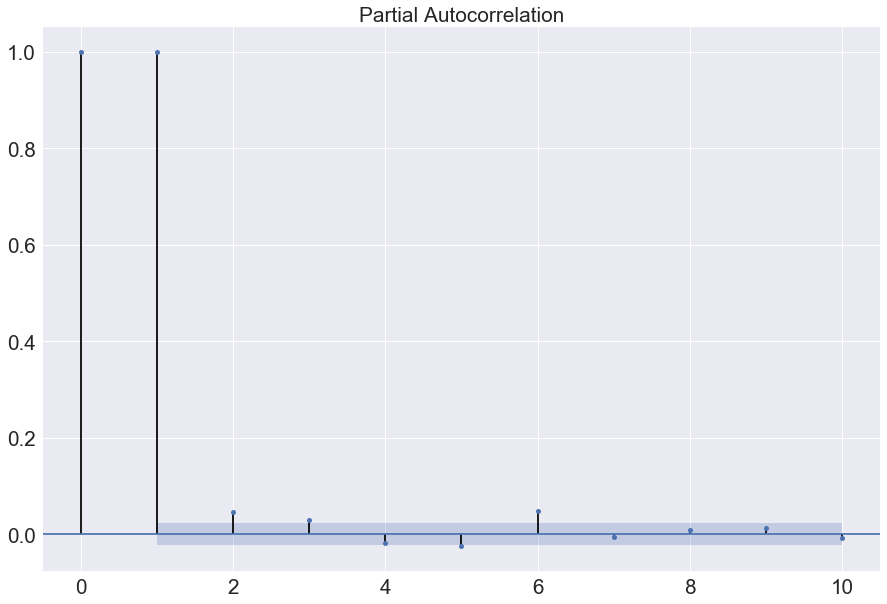

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(oil['Value'],lags=10)
plt.show()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

**p** – The lag value where the **PACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case **p=2**.


**q** – The lag value where the **ACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case **q=3**.



## ARIMA(p,d,q) Model:

In [30]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(oil.Value, order=(2, 2, 10))  
results_ARIMA = model.fit(disp=-1)  

/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [44]:
arima_pred = results_ARIMA.predict(oil['Value'].index[6000], oil['Value'].index[-1], typ="levels")

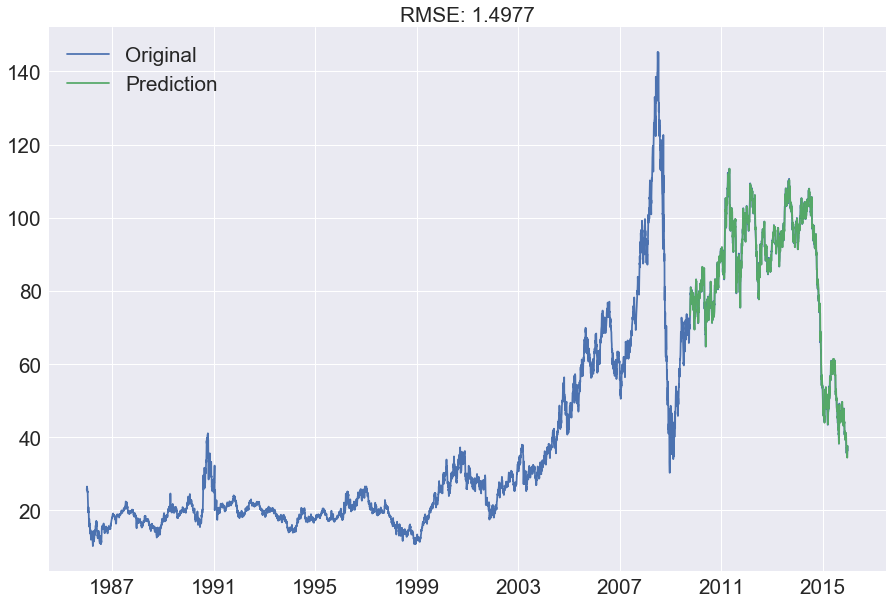

In [46]:
plt.plot(oil.Value, label='Original')
plt.plot(arima_pred, label='Prediction')
plt.legend(loc=2)
plt.title('RMSE: %.4f'% np.sqrt(sum((arima_pred-oil.Value[6000:])**2)/len(oil.Value[6000:])))

### Recent predictions:

In [48]:
len(oil.Value)

7570

In [49]:
arima_pred_recent = results_ARIMA.predict(oil['Value'].index[7500], oil['Value'].index[-1], typ="levels")

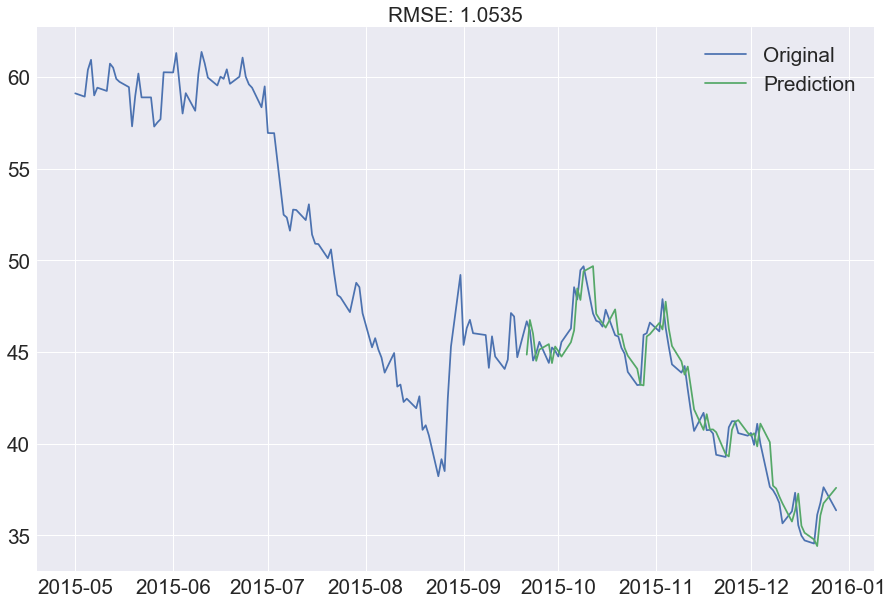

In [53]:
plt.plot(oil.Value[7400:], label='Original')
plt.plot(arima_pred_recent, label='Prediction')
plt.legend(loc=1)
plt.title('RMSE: %.4f'% np.sqrt(sum((arima_pred_recent-oil.Value[7500:])**2)/len(oil.Value[7500:])))